In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('../data/Mumbai_House_Price.csv')
print(df.head())

   bhk       type                              locality  area  price  \
0    3  Apartment   Lak And Hanware The Residency Tower   685   2.50   
1    2  Apartment     Radheya Sai Enclave Building No 2   640  52.51   
2    2  Apartment                         Romell Serene   610   1.73   
3    2  Apartment  Soundlines Codename Urban Rainforest   876  59.98   
4    2  Apartment                         Origin Oriana   659  94.11   

  price_unit          region              status  age  
0         Cr    Andheri West       Ready to move  New  
1          L    Naigaon East  Under Construction  New  
2         Cr   Borivali West  Under Construction  New  
3          L          Panvel  Under Construction  New  
4          L  Mira Road East  Under Construction  New  


In [3]:
# price_corr = df.corr()['price_in_USD'].sort_values(ascending=False)
# print(price_corr)

In [4]:
X = df.drop(columns='price')
Y = df['price']

In [5]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# X = df.drop(labels="price_in_USD",axis=1)
# for column in X:
#     if column in ["locality","region", "status", "age","type"]:
#         X[column] = le.fit_transform(X[column])
# Y = df["price_in_USD"]

In [6]:

#One-hot encode categorical variables
categorical_features = ['type', 'locality', 'price_unit', 'region', 'status', 'age']
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [7]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)



In [8]:
print(X_test_tensor.shape)

torch.Size([15208, 10024])


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

model = NeuralNetwork()


# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.layer1 = nn.Linear(X_train_tensor.shape[1], 16)
#         self.layer2 = nn.Linear(16, 16)
#         self.layer3 = nn.Linear(16, 16)
#         self.layer4 = nn.Linear(16, 16)
#         #self.dropout = nn.Dropout(p=0.25)
#         self.output = nn.Linear(16, 1)

#     def forward(self, x):
#         x = torch.relu(self.layer1(x))
#         x = torch.relu(self.layer2(x))
#         x = torch.relu(self.layer3(x))
#         x = torch.relu(self.layer4(x))
#         #x = self.dropout(x)
#         x = self.output(x)
#         return x

# model = NeuralNetwork()


In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
num_epochs = 10
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor).item()
        val_losses.append(val_loss)

        # Calculate R-squared for training set
        train_predictions = model(X_train_tensor)
        train_r2 = r2_score(Y_train_tensor.numpy(), train_predictions.numpy())
        train_r2_scores.append(train_r2)

        # Calculate R-squared for validation set
        val_predictions = model(X_test_tensor)
        val_r2 = r2_score(Y_test_tensor.numpy(), val_predictions.numpy())
        val_r2_scores.append(val_r2)
        
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}')


Epoch [1/10], Train Loss: 486.6880, Val Loss: 282.0270, Train R2: 0.7563, Val R2: 0.7405
Epoch [2/10], Train Loss: 242.8291, Val Loss: 239.8396, Train R2: 0.8053, Val R2: 0.7793
Epoch [3/10], Train Loss: 207.4555, Val Loss: 222.7763, Train R2: 0.8156, Val R2: 0.7950
Epoch [4/10], Train Loss: 187.6016, Val Loss: 200.5830, Train R2: 0.8418, Val R2: 0.8154
Epoch [5/10], Train Loss: 172.2546, Val Loss: 188.9384, Train R2: 0.8509, Val R2: 0.8261
Epoch [6/10], Train Loss: 161.2333, Val Loss: 180.0814, Train R2: 0.8614, Val R2: 0.8343
Epoch [7/10], Train Loss: 152.3196, Val Loss: 169.5261, Train R2: 0.8694, Val R2: 0.8440
Epoch [8/10], Train Loss: 143.7972, Val Loss: 165.2963, Train R2: 0.8725, Val R2: 0.8479
Epoch [9/10], Train Loss: 136.2148, Val Loss: 158.5170, Train R2: 0.8834, Val R2: 0.8541
Epoch [10/10], Train Loss: 129.2862, Val Loss: 152.6323, Train R2: 0.8896, Val R2: 0.8596


In [16]:
import pickle
pickle.dump(model, open('../models/NN3216', 'wb'))

In [17]:
loaded_model = pickle.load(open('../models/NN3216', 'rb'))

In [18]:
# Evaluate the model on the training set
loaded_model.eval()
with torch.no_grad():
    train_predictions = loaded_model(X_train_tensor)
    train_loss = criterion(train_predictions, Y_train_tensor).item()
    print(f'Mean Squared Error on training set: {train_loss:.4f}')
    # Calculate R-squared
    train_r2 = r2_score(Y_train_tensor.numpy(), train_predictions.numpy())
    print(f'R-squared on training set: {train_r2:.4f}')


Mean Squared Error on training set: 119.3843
R-squared on training set: 0.8896


In [19]:
# Evaluate the model on the test set
with torch.no_grad():
    test_predictions = loaded_model(X_test_tensor)
    test_loss = criterion(test_predictions, Y_test_tensor).item()
    print(f'Mean Squared Error on test set: {test_loss:.4f}')
    # Calculate R-squared
    test_r2 = r2_score(Y_test_tensor.numpy(), test_predictions.numpy())
    print(f'R-squared on test set: {test_r2:.4f}')

Mean Squared Error on test set: 152.6323
R-squared on test set: 0.8596


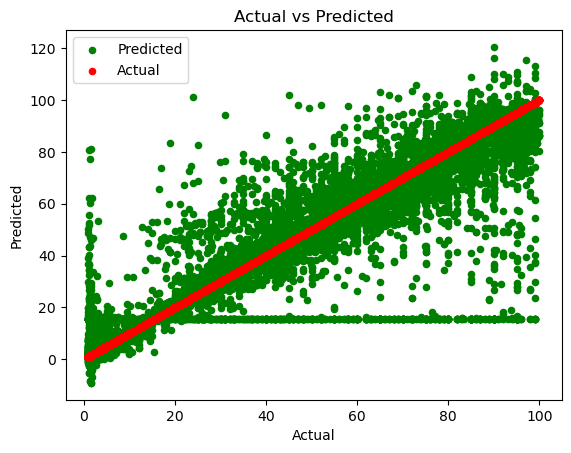

In [20]:
# Plot predictions vs actual
plt.scatter(Y_test_tensor.numpy(), test_predictions.numpy(), color='green', label='Predicted', s=20)
plt.scatter(Y_test_tensor.numpy(), Y_test_tensor.numpy(), color='red', label='Actual', s=20)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

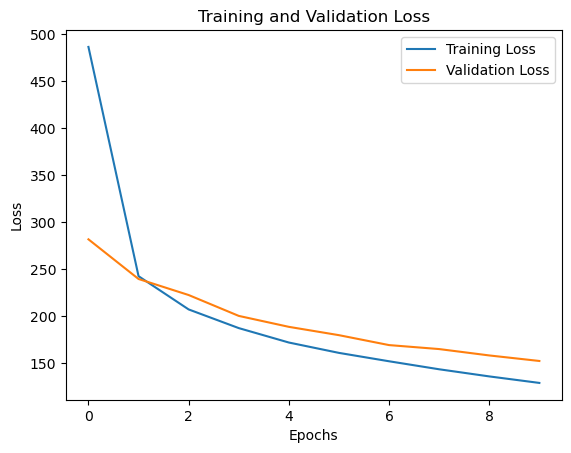

In [21]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()